# Задача

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Реализовать класс `MyBinaryLogisticRegression` для работы с логистической регрессией. Обеспечить возможность использования `l1`, `l2` и `l1l2` регуляризации и реализовать слудующие методы решения оптимизационной задачи:

*   Градиентный спуск
*   Стохастический градиентный спуск
*   Метод Ньютона

Обосновать применимость/не применимость того или иного метода оптимизации в случае использованного типа регуляризации.



Продемонстрировать применение реализованного класса на датасете про пингвинов (целевая переменная — вид пингвина). Рассмотреть все возможные варианты (регуляризация/оптимизация). Для категориального признака `island` реализовать самостоятельно преобразование `Target Encoder`, сравнить результаты классификации с `one-hot`. В качестве метрики использовать `f1-score`.

In [ ]:
import numpy as np
import pandas as pd
from scipy.special import expit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

class MyBinaryLogisticRegression:
    def __init__(self, penalty='l2', lambda_=0.01, learning_rate=0.01,
                 max_iter=1000, solver='gd', batch_size=32,
                 epsilon=1e-8, tol=1e-4):
        self.coefs_ = None
        self.feature_names_in_ = None
        self.penalty = penalty
        self.lambda_ = lambda_
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.solver = solver
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.tol = tol
        self.loss_history_ = []
        self.intercept_ = None

    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return expit(z)

    def _safe_log(self, x):
        return np.log(np.clip(x, self.epsilon, 1.0))

    def _compute_loss(self, X, y):
        m = len(y)
        z = np.dot(X, self.coefs_) + self.intercept_
        z = np.clip(z, -500, 500)
        h = self._sigmoid(z)
        h = np.clip(h, self.epsilon, 1.0 - self.epsilon)

        loss = -np.mean(y * self._safe_log(h) + (1 - y) * self._safe_log(1 - h))

        if self.penalty == 'l2':
            loss += (self.lambda_ / (2 * m)) * np.sum(self.coefs_ ** 2)
        elif self.penalty == 'l1':
            loss += (self.lambda_ / m) * np.sum(np.abs(self.coefs_))
        elif self.penalty == 'l1l2':
            loss += (self.lambda_ / (2 * m)) * (
                np.sum(self.coefs_ ** 2) + np.sum(np.abs(self.coefs_))
            )
        return loss

    def _compute_gradient(self, X, y):
        m = len(y)
        z = np.dot(X, self.coefs_) + self.intercept_
        z = np.clip(z, -500, 500)
        h = self._sigmoid(z)

        error = h - y
        grad_coefs = np.dot(X.T, error) / m
        grad_intercept = np.mean(error)

        if self.penalty == 'l2':
            grad_coefs += (self.lambda_ / m) * self.coefs_
        elif self.penalty == 'l1':
            grad_coefs += (self.lambda_ / m) * np.sign(self.coefs_)
        elif self.penalty == 'l1l2':
            grad_coefs += (self.lambda_ / m) * (self.coefs_ + np.sign(self.coefs_))

        return grad_coefs, grad_intercept

    def _compute_hessian(self, X, y):
        m = len(y)
        z = np.dot(X, self.coefs_) + self.intercept_
        z = np.clip(z, -500, 500)
        h = self._sigmoid(z)

        weights = h * (1 - h)
        weights = np.clip(weights, self.epsilon, 1.0)

        X_weighted = X * weights[:, np.newaxis]
        hessian = np.dot(X.T, X_weighted) / m

        if self.penalty == 'l2':
            hessian += (self.lambda_ / m) * np.eye(X.shape[1])

        return hessian

    def fit(self, X, y):
        self.feature_names_in_ = X.columns if hasattr(X, 'columns') else None

        X_array = X.values if hasattr(X, 'values') else X
        y_array = y.values if hasattr(y, 'values') else y
        y_array = y_array.ravel()

        self.coefs_ = np.zeros(X_array.shape[1])
        self.intercept_ = 0.0

        if self.solver == 'gd':
            self._fit_gradient_descent(X_array, y_array)
        elif self.solver == 'sgd':
            self._fit_stochastic_gradient_descent(X_array, y_array)
        elif self.solver == 'newton':
            self._fit_newton(X_array, y_array)
        else:
            raise ValueError(f"Unknown solver: {self.solver}")

        return self

    def _fit_gradient_descent(self, X, y):
        for iteration in range(self.max_iter):
            grad_coefs, grad_intercept = self._compute_gradient(X, y)
            self.coefs_ -= self.learning_rate * grad_coefs
            self.intercept_ -= self.learning_rate * grad_intercept

            loss = self._compute_loss(X, y)
            self.loss_history_.append(loss)

            if iteration > 0 and abs(self.loss_history_[-1] -
                                     self.loss_history_[-2]) < self.tol:
                break

    def _fit_stochastic_gradient_descent(self, X, y):
        m = len(y)

        for iteration in range(self.max_iter):
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for batch_start in range(0, m, self.batch_size):
                batch_end = min(batch_start + self.batch_size, m)
                X_batch = X_shuffled[batch_start:batch_end]
                y_batch = y_shuffled[batch_start:batch_end]

                grad_coefs, grad_intercept = self._compute_gradient(X_batch, y_batch)
                self.coefs_ -= self.learning_rate * grad_coefs
                self.intercept_ -= self.learning_rate * grad_intercept

            loss = self._compute_loss(X, y)
            self.loss_history_.append(loss)

            if iteration > 0 and abs(self.loss_history_[-1] -
                                     self.loss_history_[-2]) < self.tol:
                break

    def _fit_newton(self, X, y):
        if self.penalty in ['l1', 'l1l2']:
            raise ValueError(
                f"Newton's method is not applicable for {self.penalty} regularization."
            )

        for iteration in range(self.max_iter):
            grad_coefs, grad_intercept = self._compute_gradient(X, y)
            hessian = self._compute_hessian(X, y)

            try:
                newton_direction = np.linalg.solve(hessian, grad_coefs)
            except np.linalg.LinAlgError:
                newton_direction = np.linalg.lstsq(hessian, grad_coefs, rcond=None)[0]

            self.coefs_ -= self.learning_rate * newton_direction
            self.intercept_ -= self.learning_rate * grad_intercept

            loss = self._compute_loss(X, y)
            self.loss_history_.append(loss)

            if iteration > 0 and abs(self.loss_history_[-1] -
                                     self.loss_history_[-2]) < self.tol:
                break

    def predict(self, X):
        X_array = X.values if hasattr(X, 'values') else X
        z = np.dot(X_array, self.coefs_) + self.intercept_
        probabilities = self._sigmoid(z)
        return (probabilities >= 0.5).astype(int)

    def score(self, X, y):
        y_pred = self.predict(X)
        y_array = y.values if hasattr(y, 'values') else y
        return f1_score(y_array, y_pred)

In [ ]:
class SimpleTargetEncoder:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.target_stats = {}
        self.global_mean = None

    def fit(self, X, y):
        self.global_mean = y.mean()

        for category in X.unique():
            mask = X == category
            n_samples = mask.sum()
            category_mean = y[mask].mean()
            smoothed_mean = (n_samples * category_mean +
                             self.alpha * self.global_mean) / (n_samples + self.alpha)
            self.target_stats[category] = smoothed_mean

        return self

    def transform(self, X):
        return X.map(self.target_stats)

    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)


In [ ]:








def prepare_features_onehot(df: pd.DataFrame):
    numeric = ['bill_length_mm', 'bill_depth_mm',
               'flipper_length_mm', 'body_mass_g', 'year']
    X_num = df[numeric].copy()
    X_island = pd.get_dummies(df['island'], prefix='island', drop_first=True)
    X = pd.concat([X_num, X_island], axis=1)
    y = df['target']
    return X, y


def prepare_features_target(df: pd.DataFrame):
    numeric = ['bill_length_mm', 'bill_depth_mm',
               'flipper_length_mm', 'body_mass_g', 'year']
    X_num = df[numeric].copy()
    y = df['target']

    enc_island = SimpleTargetEncoder(alpha=1.0)
    X_island = enc_island.fit_transform(df['island'], y).to_frame('island_target')
    X = pd.concat([X_num, X_island], axis=1)
    return X, y


def standardize_train_test(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X.columns
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=X.columns
    )
    return X_train_scaled, X_test_scaled, y_train, y_test


def build_results_dataset(df: pd.DataFrame) -> pd.DataFrame:

    X_oh, y_oh = prepare_features_onehot(df)
    print(X_oh)
    X_te, y_te = prepare_features_target(df)

    X_train_oh, X_test_oh, y_train_oh, y_test_oh = standardize_train_test(X_oh, y_oh)
    X_train_te, X_test_te, y_train_te, y_test_te = standardize_train_test(X_te, y_te)

    penalties = ['none', 'l2', 'l1', 'l1l2']
    solvers = ['gd', 'sgd', 'newton']
    encodings = ['one_hot', 'target_enc']

    rows = []

    for encoding in encodings:
        if encoding == 'one_hot':
            X_train = X_train_oh
            X_test = X_test_oh
            y_train = y_train_oh
            y_test = y_test_oh
        else:
            X_train = X_train_te
            X_test = X_test_te
            y_train = y_train_te
            y_test = y_test_te

        for solver in solvers:
            for penalty in penalties:
                if solver == 'newton' and penalty in ['l1', 'l1l2']:
                    rows.append({
                        'encoding': encoding,
                        'solver': solver,
                        'penalty': penalty,
                        'lambda_': 0.01,
                        'f1_train': None,
                        'f1_test': None,
                        'status': 'not_applicable_newton_l1'
                    })
                    continue


                eff_penalty = penalty if penalty != 'none' else 'l2'
                lambda_ = 0.0 if penalty == 'none' else 100000

                try:
                    model = MyBinaryLogisticRegression(
                        penalty=eff_penalty,
                        lambda_=lambda_,
                        learning_rate=0.01,
                        max_iter=1000,
                        solver=solver,
                        batch_size=32
                    )
                    model.fit(X_train, y_train)

                    f1_tr = f1_score(y_train, model.predict(X_train))
                    f1_te = f1_score(y_test, model.predict(X_test))

                    rows.append({
                        'encoding': encoding,
                        'solver': solver,
                        'penalty': penalty,
                        'lambda_': lambda_,
                        'f1_train': f1_tr,
                        'f1_test': f1_te,
                        'status': 'ok'
                    })
                except Exception as e:
                    rows.append({
                        'encoding': encoding,
                        'solver': solver,
                        'penalty': penalty,
                        'lambda_': lambda_,
                        'f1_train': None,
                        'f1_test': None,
                        'status': f'error: {str(e)[:80]}'
                    })

    results_df = pd.DataFrame(rows)
    return results_df





results_df = build_results_dataset(df)

print("Датасет результатов:")
print(results_df.head())



     bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  year  \
0              39.1           18.7              181.0       3750.0  2007   
1              39.5           17.4              186.0       3800.0  2007   
2              40.3           18.0              195.0       3250.0  2007   
3              36.7           19.3              193.0       3450.0  2007   
4              39.3           20.6              190.0       3650.0  2007   
..              ...            ...                ...          ...   ...   
269            47.2           13.7              214.0       4925.0  2009   
270            46.8           14.3              215.0       4850.0  2009   
271            50.4           15.7              222.0       5750.0  2009   
272            45.2           14.8              212.0       5200.0  2009   
273            49.9           16.1              213.0       5400.0  2009   

     island_Dream  island_Torgersen  
0           False              True  
1          

In [ ]:
results_df

,encoding,solver,penalty,lambda_,f1_train,f1_test,status
0,one_hot,gd,none,0.00,1.000000,1.000000,ok
1,one_hot,gd,l2,100000.00,0.000000,0.000000,ok
2,one_hot,gd,l1,100000.00,0.419753,0.524590,ok
3,one_hot,gd,l1l2,100000.00,0.000000,0.000000,ok
4,one_hot,sgd,none,0.00,1.000000,1.000000,ok
5,one_hot,sgd,l2,100000.00,0.000000,0.000000,ok
6,one_hot,sgd,l1,100000.00,0.669604,0.700000,ok
7,one_hot,sgd,l1l2,100000.00,0.000000,0.000000,ok
8,one_hot,newton,none,0.00,1.000000,1.000000,ok
9,one_hot,newton,l2,100000.00,0.711765,0.705882,ok


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])


model = MyBinaryLogisticRegression(
    penalty='l2',
    lambda_=0.01,
    learning_rate=0.01,
    max_iter=2000,
    solver='sgd',
    batch_size=32
)

model.fit(X_pca_df, y)

w = model.coefs_
b = model.intercept_



x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 20),
    np.linspace(y_min, y_max, 20)
)

if abs(w[2]) < 1e-6:
    zz = np.zeros_like(xx) * np.nan
else:
    zz = -(w[0] * xx + w[1] * yy + b) / w[2]


X0 = X_pca[y == 0]
X1 = X_pca[y == 1]

scatter_0 = go.Scatter3d(
    x=X0[:, 0],
    y=X0[:, 1],
    z=X0[:, 2],
    mode='markers',
    name='Класс 0 (не Adelie)',
    marker=dict(size=5, color='blue', opacity=0.8),
    hovertemplate='PC1: %{x:.2f}<br>PC2: %{y:.2f}<br>PC3: %{z:.2f}<extra>Не Adelie</extra>'
)

scatter_1 = go.Scatter3d(
    x=X1[:, 0],
    y=X1[:, 1],
    z=X1[:, 2],
    mode='markers',
    name='Класс 1 (Adelie)',
    marker=dict(size=5, color='orange', opacity=0.8),
    hovertemplate='PC1: %{x:.2f}<br>PC2: %{y:.2f}<br>PC3: %{z:.2f}<extra>Adelie</extra>'
)

plane = go.Surface(
    x=xx,
    y=yy,
    z=zz,
    name='Разделяющая плоскость (MyBinaryLogisticRegression)',
    colorscale='RdBu',
    opacity=0.4,
    showscale=False,
    hoverinfo='skip'
)

fig = go.Figure(data=[scatter_0, scatter_1, plane])

fig.update_layout(
    title=dict(
        text='3D PCA + MyBinaryLogisticRegression: разделяющая плоскость',
        x=0.5
    ),
    scene=dict(
        xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0]:.1%})',
        yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1]:.1%})',
        zaxis_title=f'PC3 ({pca.explained_variance_ratio_[2]:.1%})',
        xaxis=dict(backgroundcolor='rgb(240,240,240)'),
        yaxis=dict(backgroundcolor='rgb(240,240,240)'),
        zaxis=dict(backgroundcolor='rgb(240,240,240)'),
    ),
    legend=dict(
        x=0.02, y=0.98,
        bgcolor='rgba(255,255,255,0.7)'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

# Теоретическая часть

Пусть данные имеют вид
$$
(x_i, y_i), \quad y_i \in \{1, \ldots,M\}, \quad i \in \{1, \ldots, N\},
$$
причем первая координата набора признаков каждого объекта равна $1$.
Используя `softmax`-подход, дискриминативная модель имеет следующий вид
$$
\mathbb P(C_k|x) = \frac{\exp(\omega_k^Tx)}{\sum_i \exp(\omega_i^Tx)}.
$$
Для написания правдоподобия удобно провести `one-hot` кодирование меток класса, сопоставив каждому объекту $x_i$ вектор $\widehat y_i = (y_{11}, \ldots, y_{1M})$ длины $M$, состоящий из нулей и ровно одной единицы ($y_{iy_i} = 1$), отвечающей соответствующему классу. В этом случае правдоподобие имеет вид
$$
\mathbb P(D|\omega) = \prod_{i = 1}^{N}\prod_{j = 1}^M \mathbb P(C_j|x_i)^{y_{ij}}.
$$
Ваша задача: вывести функцию потерь, градиент и гессиан для многоклассовой логистической регрессии. Реализовать матрично. На синтетическом примере продемонстрировать работу алгоритма, построить гиперплоскости, объяснить классификацию

Вывод формул лежит в рукописном виде в гитхабе

Обучение остановлено на итерации 91 (сходимость достигнута)
[[-0.12786037  0.15928871 -0.02136696]
 [-0.41013967  0.83516094 -0.41447387]
 [ 0.44679748  0.07826529 -0.50629104]]

Точность на тестовой выборке: 0.9967

ВИЗУАЛИЗАЦИЯ ГРАНИЦ РЕШЕНИЙ

Уравнения границ решений (в форме w1*x1 + w2*x2 + b = 0):
Между классами 0 и 1:
  -1.245*x1 + 0.369*x2 + (-0.287) = 0
Между классами 0 и 2:
  0.004*x1 + 0.953*x2 + (-0.106) = 0
Между классами 1 и 2:
  1.250*x1 + 0.585*x2 + (0.181) = 0


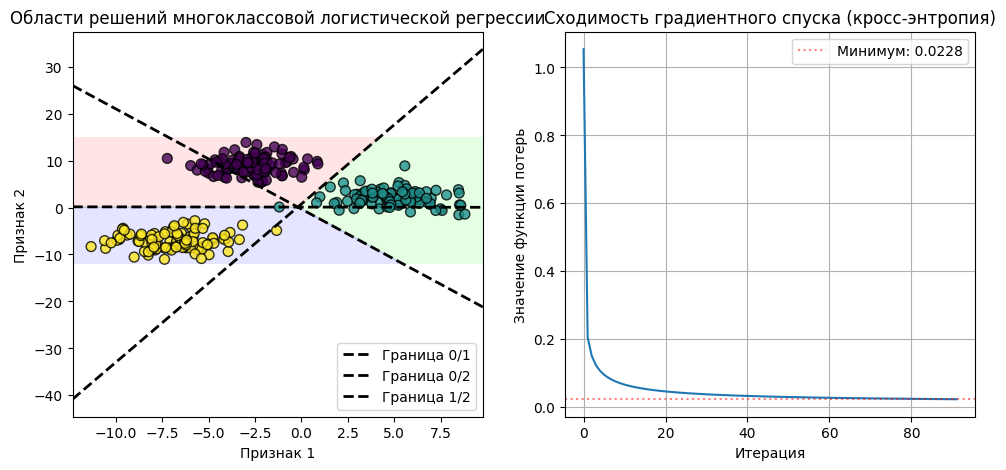

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

class SoftmaxRegressionNoReg:
    def __init__(self, learning_rate=0.1, max_iters=1000, tol=1e-4):
        self.lr = learning_rate
        self.max_iters = max_iters
        self.tol = tol
        self.W = None
        self.loss_history = []

    def softmax(self, Z):

        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

    def cross_entropy_loss(self, X, y_true_onehot, probs):
        N = X.shape[0]
        loss = -np.sum(y_true_onehot * np.log(probs + 1e-15)) / N
        return loss

    def fit(self, X, y):
        N, D = X.shape

        self.classes_ = np.unique(y)
        M = len(self.classes_)
        Y_onehot = np.eye(M)[y]
        self.W = np.random.randn(D, M) * 0.01

        for i in range(self.max_iters):
            scores = X @ self.W
            probs = self.softmax(scores)
            loss = self.cross_entropy_loss(X, Y_onehot, probs)
            self.loss_history.append(loss)

            grad = (1/N) * (X.T @ (probs - Y_onehot))  # (D, M)

            self.W -= self.lr * grad

            if i > 0 and abs(self.loss_history[-2] - loss) < self.tol:
                print(f'Обучение остановлено на итерации {i} (сходимость достигнута)')
                break

        print(self.W)
        print()

        return self

    def predict_proba(self, X):
        scores = X @ self.W
        return self.softmax(scores)

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

    def compute_decision_boundaries(self):
        boundaries = {}
        M = self.W.shape[1]

        for i in range(M):
            for j in range(i+1, M):
                w_diff = self.W[1:, i] - self.W[1:, j]
                bias_diff = self.W[0, i] - self.W[0, j]
                boundaries[(i, j)] = (w_diff, bias_diff)

        return boundaries


np.random.seed(42)
N = 300
X, y = make_blobs(n_samples=N, centers=3, n_features=2,
                  cluster_std=1.8, random_state=42)

X_with_bias = np.c_[np.ones((N, 1)), X]


model = SoftmaxRegressionNoReg(learning_rate=0.1, max_iters=2000)
model.fit(X_with_bias, y)


train_acc = np.mean(model.predict(X_with_bias) == y)
print(f"Точность на тестовой выборке: {train_acc:.4f}")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

grid_points = np.c_[np.ones((xx.ravel().shape[0], 1)),
                    xx.ravel(), yy.ravel()]

Z = model.predict(grid_points)
Z = Z.reshape(xx.shape)

from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis',
            edgecolor='k', s=50, alpha=0.8)
plt.title('Области решений многоклассовой логистической регрессии')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')

boundaries = model.compute_decision_boundaries()

for (class_i, class_j), (w, b) in boundaries.items():
    if abs(w[1]) > 1e-3:
        y_boundary = (-w[0] * xx[0] - b) / w[1]
        plt.plot(xx[0], y_boundary, 'k--', linewidth=2,
                 label=f'Граница {class_i}/{class_j}')
    else:
        x_val = -b / w[0]
        plt.axvline(x=x_val, color='k', linestyle='--', linewidth=2)

plt.legend(loc='best')

plt.subplot(1, 3, 2)
plt.plot(model.loss_history)
plt.title('Сходимость градиентного спуска (кросс-энтропия)')
plt.xlabel('Итерация')
plt.ylabel('Значение функции потерь')
plt.grid(True)

min_loss = min(model.loss_history)
plt.axhline(y=min_loss, color='r', linestyle=':', alpha=0.5,
            label=f'Минимум: {min_loss:.4f}')
plt.legend()

print("\n" + "="*60)
print("ВИЗУАЛИЗАЦИЯ ГРАНИЦ РЕШЕНИЙ")
print("="*60)

print("\nУравнения границ решений (в форме w1*x1 + w2*x2 + b = 0):")
for (class_i, class_j), (w, b) in boundaries.items():
    print(f"Между классами {class_i} и {class_j}:")
    print(f"  {w[0]:.3f}*x1 + {w[1]:.3f}*x2 + ({b:.3f}) = 0")